In [4]:
import tensorflow as tf
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
#import seaborn as sns
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = 12, 8

In [3]:
class foo(object):
    pass
FLAGS = foo()
FLAGS.num_features = 3 # hard coded, not nice

# Filt-Filt operation definition

- FeedBack filter components `[M]`:   $A = a_0, a_1, a_2 \dots a_M$, where $a_0 = 0$ by definition
- FeedForward filter components`[N]`:   $B = b_0, b_1, b_2 \dots b_N$

```
y(t) = x(t)*b(0) + x(t-1)*b(1) + x(t-2)*b(2) ... x(t-M)*b(N)
                 - y(t-1)*a(1) - y(t-2)*a(2) ... y(t-N)*a(M)
```

$$
y_t = \sum_{i=0}^{N} x_{t-i} \cdot b_{i} - \sum_{i=1}^{M} y_{t-i} \cdot a_{i}
$$


```
y(t) = x[t-N : t] * b[::-1] - y[t-M : t-1] * a[::-1]
```

for faster computation let $s$ be $s := x \ast b$, where $\ast$ is the convolution operator, since all values of $x$ is known at computation time

```
y(t) = s[t] - y[t-M : t-1] * a[::-1]
```


In [99]:
l = list(range(10))
l[:0:-1]

[9, 8, 7, 6, 5, 4, 3, 2, 1]

In [204]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# [batch_size, sequnce_length, channels]
x = tf.placeholder(tf.float32, shape=[None, None, None], name='x_vector')
# [sequnce_length]
x_single = tf.placeholder(tf.float32, shape=[None], name='x_vector')
# [filter_length(N/M), num_filters]
a = tf.placeholder(tf.float32, shape=[None, None], name='a_vector')
b = tf.placeholder(tf.float32, shape=[None, None], name='b_vector')

def get_filt(b, a, x, batch_samples=True):
    
    if len(b.shape) == 1:
        b = b[:, None]
    if len(a.shape) == 1:
        a = b[:, None]
    if len(x.shape) == 1:
        # single sample with single channel
        batch_samples = False
        x = x[:, None]
    if len(x.shape) == 2:
        if batch_samples:
            # [batch_size, seq_len, 1]
            x = x[:, :, None]
        else:
            # [1, seq_len, channels]
            x = x[None, :, :]
    
    if len(a.shape) != 2 or len(b.shape) != 2:
        raise ValueError('Filter dimension(s) must be the following: [filter_length, num_filters] or [filter_length]')
    
    if len(x.shape) != 3:
        raise ValueError('Sample dimension(s) must be the following: [batch_size, sequnce_length, channels] or [batch_size, sequnce_length] if `batch_samples` is True or [sequnce_length, channels] otherwise')
        
    b /= a[0]
    a /= a[0]
    
    a = a[:0:-1]
    b = b[::-1]
    
    batch_size = tf.shape(x)[0]
    sequence_length = tf.shape(x)[1]
    N = tf.shape(b)[0]
    M = tf.shape(a)[0]
    num_filters = tf.shape(a)[1]
    edge = (tf.maximum(N, M) - 1)
    
    
    y = tf.zeros(dtype=tf.float32, 
                 shape=[batch_size, edge, num_filters],
                 name='y_zeros_init')

    x_padded = tf.pad(x, [[0, 0], [edge, edge], [0, 0]], mode='SYMMETRIC')
    #x_padded = tf.pad(x, [[0, 0], [edge, edge], [0, 0]], mode='CONSTANT')

    def prod(a, b, **kwargs):
        return tf.reduce_sum(a * b, axis=1, **kwargs)

    def body(y, a, t):
        y_curr = prod(x_padded[:, t:t+N:], [b]) - prod(y[:, -M:], [a])
        y = tf.concat([y, y_curr[:, None, :]], axis=1, name='y')

        t += 1
        return y, a, t

    def cond(y, a, t):
        return  t < sequence_length
    
    wl = tf.while_loop(cond, body, [y, a, 0], parallel_iterations=1, back_prop=False)
    filt = wl[0][:, edge:]

    t = 9
    return  filt#prod(x[:, t:t+N:, None], [b]), prod(y[:, -M:], [a])


In [205]:
test_op = get_filt(b, a, x_single)
X = np.arange(10, dtype=np.float32)
#X = np.sin(np.arange(10, dtype=np.float32))[None]
#B, A = signal.ellip(4, 0.01, 120, 0.125)  # Filter to be applied.
B = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
A = np.array([1, 0, 0])
test_feed = {
    b: B[:, None],
    a: A[:, None],
    x_single: X
}
res = sess.run(test_op, test_feed)
res.shape

(1, 10, 1)

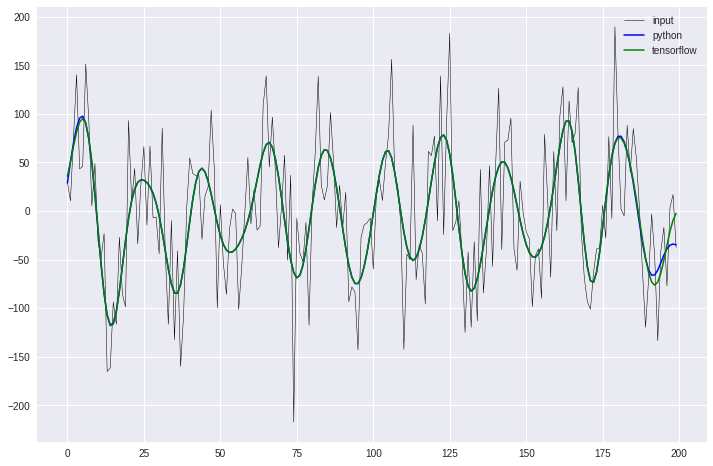

In [221]:
#tf.global_variables_initializer().run()

def get_filtfilt(b, a, x):
    filt = get_filt(b, a, x)
    filtfilt = get_filt(b, a, filt[:, ::-1])[:, ::-1]
    
    return filtfilt

filtfilt = get_filtfilt(b, a, x_single)

np.random.seed(42)
N = 200
#X = np.arange(N, dtype=np.float32) + 3
#X = np.sin(np.arange(N, dtype=np.float32)/3.14)
X = np.sin(np.arange(N, dtype=np.float32)/3.14)*60 + np.random.randn(N)*60
B, A = signal.ellip(4, 0.01, 120, 0.125)  # Filter to be applied.
#B = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])
#A = np.array([1, 0, 0, 1])
test_feed = {
    b: B[:, None],
    a: A[:, None],
    x_single: X
}
res = sess.run(filtfilt, test_feed).squeeze()
filtfilt_y = signal.filtfilt(B, A, X)
#print(res[0,:,0])

plt.figure(1)
plt.plot(X, 'k-', label='input', linewidth=0.5)
plt.plot(filtfilt_y, 'b-', linewidth=1.5, label='python')
plt.plot(res, 'g-', linewidth=1.5, label='tensorflow')
plt.legend(loc='best')
plt.show()

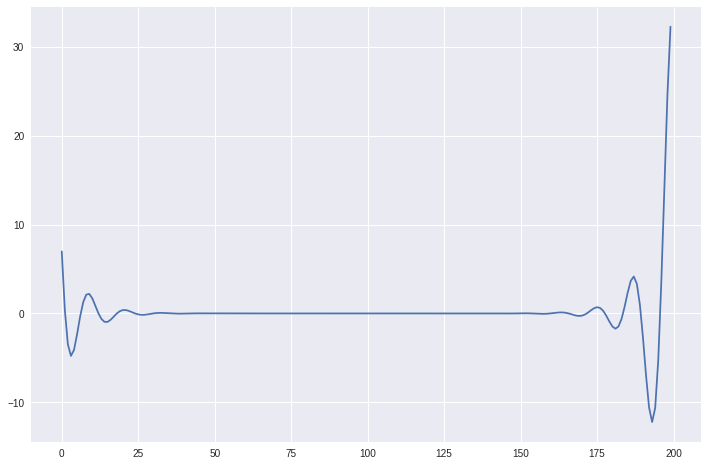

In [224]:
res.shape, filtfilt_y.shape

plt.plot(res-filtfilt_y)
#((res-filtfilt_y)[50:100])

# Implementing signal.filtfilt (forward-backward filter) in python

In [6]:
b, a = signal.ellip(4, 0.01, 120, 0.125)  # Filter to be applied.
np.random.seed(42)

n = 100
sig = np.random.randn(n)**3 + 3*np.random.randn(n).cumsum()

fgust = signal.lfilter(b, a, sig)
sig2 = sig
sig = [sig[0]]*5 + sig.tolist() + [sig[-1]]*5
sig3 = sig
h = np.convolve(b, sig)
y = np.zeros
y = np.array([0.]*(len(h)+len(a)))
h = h.tolist() + [0]*len(a)
for i,_ in enumerate(h): #range(len(h))
    if i < len(a): continue
    y[i] = h[i] - np.dot(y[i:i-len(a):-1], a)
'''    
x = y[::-1]
h = np.convolve(b, x)
y = np.array([0.]*(len(h)+len(a)))
h = h.tolist() + [0]*len(a)
for i,_ in enumerate(h):
    if i < len(a): continue
    y[i] = h[i] - np.dot(y[i:i-len(a):-1], a)
y = y[::-1]

sig = sig2

'''
plt.figure(1)
plt.plot(sig, 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=1.5, label='built-in')
plt.plot(y[len(a)+len(b)-1+5:-(len(a)+len(b)-1+5)], 'g-', linewidth=1.5, label='manual')
plt.legend(loc='best')
plt.show()

NameError: name 'A' is not defined

# Attempt to implement in signal.filtfilt in tensorflow

In [111]:
def create_filter(filter):
    return tf.Variable(np.array(filter).reshape((len(filter),1,1)).astype(np.float32))

In [387]:
def filt(filter_b, filter_a, input_op, len_b, len_a):
    padding = len_a + len_b
    pad_op = tf.pad(input_op, paddings=[[0, 0], [padding, 0], [0, 0]])#, mode='SYMMETRIC')
    conv_op = tf.nn.conv1d(pad_op, filter_b, stride=1, padding='VALID')
    
    y = [[conv_op[0,i]] for i in range(len_a+1)]
    for i in range(len_a+1, conv_op.get_shape()[1]):
        # ha alább kiveszem a szorzást (tf.multiply), akkor nem száll el...
        y.append([conv_op[0,i] - tf.reduce_sum(tf.multiply(y[i-1:i-len_a-1:-1],filter_a))])
    return tf.transpose(tf.stack(y[:len_a:-1]), [1,0,2])

In [388]:
def filtfilt(filter_b, filter_a, input_op):
    filt_b = create_filter(filter_b)
    filt_a = create_filter(filter_a)
    y = filt(filt_b, filt_a, input_op, len(filter_b), len(filter_a))
    y = filt(filt_b, filt_a, y, len(filter_b), len(filter_a))
    return y

In [389]:
max_length = 50
input_op = tf.placeholder(tf.float32, [1,max_length,1], 'input')
#b_LPF = [1./32] + [0]*5 + [-1./16] + [0]*5 + [1./32]
#a_LPF = [1.,-1.99, 1.] + [0]*10
b_LPF, a_LPF = signal.ellip(4, 0.01, 120, 0.125) # tesztszűrők...
y_LP  = filtfilt(b_LPF, a_LPF, input_op)
print(y_LP)

ValueError: Shapes must be equal rank, but are 4 and 2
	From merging shape 0 with other shapes. for 'transpose_62/packed' (op: 'Pack') with input shapes: [1,1,5,5], [1,1], [1,1], [1,1], [1,1].

In [368]:
n = 50
sig = np.random.randn(n)**3 + 3*np.random.randn(n).cumsum() # ...a tesztmintához
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    filter_a = create_filter(a_LPF)
    result = sess.run(y_LP, feed_dict={input_op: sig.reshape((1, n, 1)).astype(np.float32)})
    print(result.reshape((n)))

InvalidArgumentError: You must feed a value for placeholder tensor 'input_106' with dtype float and shape [1,50,1]
	 [[Node: input_106 = Placeholder[dtype=DT_FLOAT, shape=[1,50,1], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: transpose_47/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_716_transpose_47", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_106', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-361-fe941c4f929a>", line 2, in <module>
    input_op = tf.placeholder(tf.float32, [1,max_length,1], 'input')
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_106' with dtype float and shape [1,50,1]
	 [[Node: input_106 = Placeholder[dtype=DT_FLOAT, shape=[1,50,1], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: transpose_47/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_716_transpose_47", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


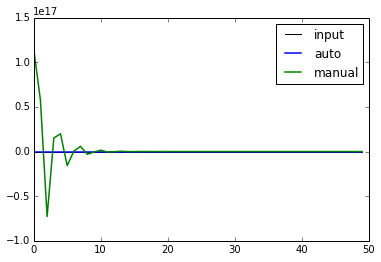

In [185]:
fgust = signal.filtfilt(b_LPF, a_LPF, sig)

plt.figure(1)
plt.plot(sig, 'k-', label='input')
plt.plot(fgust, 'b-', linewidth=1.5, label='auto')
plt.plot(result.reshape((n)), 'g-', linewidth=1.5, label='manual')
plt.legend(loc='best')
plt.show()

# Original python code

In [3]:
def CPU_time_domain_features(mini_batch):
    feature_vector=[]
    for y0 in mini_batch:
        ## import signal
        fs=300.
        ## PT algorithm

        # LP filter
        b_LPF=[1./32]+ [0]*5 + [-1./16] +[0]*5 +[1./32]
        a_LPF=[1.,-1.99, 1.] + [0]*10
        y_LP = signal.filtfilt(b_LPF, a_LPF, y0)

        #HP Filter 
        b_HPF=[-1./32]+[0]*15+[1,-1]+[0]*14+[1./32]
        a_HPF=[1.,-0.99]+[0]*31;
        y_HP = signal.filtfilt(b_HPF, a_HPF, y0)

        #Differentiation 
        b_DEV=[1./4, 1./8, 0, -1./8,-1./4]
        a_DEV=[1]+[0]*4
        y_DEV = signal.filtfilt(b_DEV, a_DEV, y_HP)


        #Squaring
        y_SQ=y_DEV*y_DEV

        #Smoothing
        b_SM=[1./30]*30;
        a_SM=[1]+[0]*30;
        y_SM1 = signal.filtfilt(b_SM, a_SM, y_SQ)
        y_SM2 = signal.filtfilt(b_SM, a_SM, y_SM1)


        #PT Squaring
        y_QRS=(y_HP*y_HP*y_HP)/200000.
        y_PT=np.asarray(y0);

        #P-Q-R-S-T indexes and values
        P_index=[];P_value=[];y0_P=[]
        Q_index=[];Q_value=[];y0_Q=[]
        R_index=[];R_value=[];y0_R=[]
        S_index=[];S_value=[];y0_S=[]
        T_index=[];T_value=[];y0_T=[]

        #Variability indexes
        pNN50=[];NN50=0
        pPR20=[];PR20=0
        pQT20=[];QT20=0
        pQS5=[];QS5=0
        ind_QS=0;

        ind=0;
        max_QRS_d=0.2*fs;
        max_RR_d=0.8*fs;
        max_PQ_d=0.45*fs

        #Q-R-S detection
        for index,value in enumerate(y_QRS):
            if index < int(max_RR_d/2) or index > len(y_QRS)-int(max_RR_d/2): continue
            if y_SM2[index] == max(y_SM2[index-int(max_RR_d/2):index+int(max_RR_d/2)]):
                R_index.append(index/fs)
                R_value.append(y_SM2[index])
                y0_R.append(y0[index])
                if 2<len(R_index) and abs((R_index[end]-R_index[-1])-(R_index[-1]-R_index[-2]))>0.05:
                    NN50+=1

            if len(R_index) < 2: continue
            start=int(R_index[len(R_index)-1]*fs-max_QRS_d/2)
            middle=int(R_index[len(R_index)-1]*fs)
            stop= int(R_index[len(R_index)-1]*fs+max_QRS_d/2)
            mod_index=int(index-max_QRS_d)


            if start<mod_index<middle and y_QRS[mod_index]==min(y_QRS[start:middle]):
                Q_index.append((index-max_QRS_d)/fs)
                Q_value.append(y_QRS[mod_index])
                y0_Q.append(y0[index])

            if middle<index<stop and value==min(y_QRS[middle:stop]):
                S_index.append(index/fs)
                S_value.append(y_QRS[index])
                y0_S.append(y0[index])
                '''ind_QS=len(Q_index)-1
                if 1<ind_QS<len(R_index):
                    #print ind_QS,Q_index[ind_QS],S_index[ind_QS]
                    if abs(abs(S_index[ind_QS]-Q_index[ind_QS])-abs(S_index[ind_QS-1]-Q_index[ind_QS-1]))>0.005:
                        QS5=QS5+1'''

            #Delet QRS 
            if 1<len(Q_index)<len(R_index) and 1<len(S_index)<len(R_index) :
                Relative_Q_indexes=list(abs(np.array(Q_index)-R_index[len(R_index)-1]))
                min_Q_value=min(np.array(Relative_Q_indexes))
                Relative_S_indexes=list(abs(np.array(S_index)-R_index[len(R_index)-1]))
                min_S_value=min(np.array(Relative_S_indexes))
                min_Q_index=Relative_Q_indexes.index(min_Q_value)
                min_S_index=Relative_S_indexes.index(min_S_value)

                if (Q_index[min_Q_index]<R_index[len(R_index)-1]<S_index[min_S_index]):
                    Q_ind=Q_index[min_Q_index]*fs #Q_index[len(Q_index)-1]*fs
                    S_ind=S_index[min_S_index]*fs #S_index[len(S_index)-1]*fs
                    ind=index-(S_ind-Q_ind)
                    if  Q_ind<ind<S_ind:
                        y_PT[int(ind)]=((y_PT[int(Q_ind)]/y_PT[int(S_ind)])/(Q_ind/S_ind))*(ind-Q_ind) 


                    Relative_Q_indexes_but1=list(abs(np.array(Q_index)-R_index[len(R_index)-2]))
                    min_Q_value_but1=min(np.array(Relative_Q_indexes))
                    Relative_S_indexes_but1=list(abs(np.array(S_index)-R_index[len(R_index)-2]))
                    min_S_value_but1=min(np.array(Relative_S_indexes))
                    min_Q_index_but1=Relative_Q_indexes.index(min_Q_value)
                    min_S_index_but1=Relative_S_indexes.index(min_S_value)
                    if (Q_index[min_Q_index_but1]<R_index[len(R_index)-2]<S_index[min_S_index_but1]):
                        ind_QS=ind_QS+1
                        if abs(abs(S_index[min_S_index]-Q_index[min_Q_index])-abs(S_index[min_S_index_but1]-Q_index[min_Q_index_but1]))>0.005:
                            QS5=QS5+1

        #Smoothing
        y_SQ_PT=y_PT*y_PT/10.
        b_SM=[1./30]*30;
        a_SM=[1]+[0]*30;
        y_SM1_PT = signal.filtfilt(b_SM, a_SM, y_SQ_PT)
        y_SM2_PT = signal.filtfilt(b_SM, a_SM, y_SM1_PT)
        '''
        # P-T detection
        i=0
        for index,value in enumerate(y_SM2_PT):
            P_ind =int(Q_index[i]*fs-max_QRS_d)
            Q_ind =int(Q_index[i]*fs)
            S_ind =int(S_index[i]*fs)
            T_ind =int(S_index[i]*fs+max_QRS_d)
            if index>T_ind and i<len(Q_index)-1:
                i=i+1
                
            if P_ind<index<Q_ind:
                if y_SM2_PT[index-1]<value>y_SM2_PT[index+1]:
                    P_index.append(index/fs)
                    P_value.append(value)
                    y0_P.append(y0[index])
                    ind_P=len(P_index)-1
                    if 1<ind_P:
                        #print i,PR20,P_index[ind_P],R_index[i],P_index[ind_T-1],R_index[i-1]
                        if abs(abs(R_index[i]-P_index[ind_P])-abs(R_index[i-1]-P_index[ind_P-1]))>0.02:
                            PR20=PR20+1
            
            if S_ind<index<T_ind:
                if y_SM2_PT[index-1]<value>y_SM2_PT[index+1]:
                    T_index.append(index/fs)
                    T_value.append(value)
                    y0_T.append(y0[index])
                    ind_T=len(T_index)-1
                    if 1<ind_T:
                        #print i,QT20,T_index[ind_T],Q_index[i],T_index[ind_T-1],Q_index[i-1]
                        if abs(abs(T_index[ind_T]-Q_index[i])-abs(T_index[ind_T-1]-Q_index[i-1]))>0.02:
                            QT20=QT20+1'''

        # Features
        pNN50=round(float(NN50)/(ind_R+1),3)
        pQS5=round(float(QS5)/(ind_QS+1),3)    
        '''pQT20=round(float(QT20)/(ind_T+1),3)    
        pPR20=round(float(PR20)/(ind_P+1),3)
        pPR=round(float(len(P_index))/(len(R_index)-1),3)'''
        pQR=round(float(len(Q_index))/(len(R_index)-1),3)
        pSR=round(float(len(S_index))/(len(R_index)-1),3)
        '''pTR=round(float(len(T_index))/(len(R_index)-1),3)'''
        
        #features=[pNN50,pQS5,pQT20,pPR20,pPR,pQR,pSR,pTR]
        features=[pNN50,pQR,pSR]
        feature_vector.append(features)
    feature_vector=np.asarray(feature_vector)
    return feature_vector

In [4]:
class model(object):
    '''
    Calculates fourier descriptors from input features and returns selected frequency magnitudes
    '''

    def get_layers(self, seq_len, in_node):
        '''
        generate layers of the network- there is only one layer creating the time domain descriptors
        '''    
        
        with tf.variable_scope('tdomain_module'):
            # Converting to NHWC where N is batch and H will be seq_len
            h = in_node[..., None, None]

            h=tf.squeeze(h,[2,3])
            #f=tf.py_func(CPU_time_domain_features, [h], tf.float64)
            #f=tf.cast(f, tf.float32)
            #out=tf.reshape(f,[-1,FLAGS.num_features])
            b_LPF = tf.constant([1./32] + [0]*5 + [-1./16] + [0]*5 + [1./32], tf.float32, [])
            out = tf.nn.conv1d()
             
        return out, seq_len


    def get_name(self):
        return '--timedomain1x'
    
    def build_graph(self, model_name=None):
        if not model_name:
            model_name = self.get_name()
        self.name = model_name
        
        self.output, self.seq_len = self.get_layers(self.seq_len, self.input)
    
        
    def __init__(self,  seq_len, input_op,
            out_dims=[FLAGS.num_features], #hard ocded not nice
            model_name=None):
        '''
        Initializer default vales use tf.app.flags
        returns an object, whose main fields are tensorflow graph nodes.
        '''
        
        self.seq_len = seq_len
        self.input = input_op
        
        self.out_dims = out_dims
        self.name = self.get_name()
        with tf.variable_scope('TimeDomain'):
            print('\nTimeDomain' + self.name)
            self.build_graph()

In [ ]:
def get_output(seq_len, input_op, **kwargs):
    ff = model(seq_len, input_op, **kwargs)
    return ff.output